In [1]:
import pandas as pd
import numpy as np
import pickle
import torch.nn as nn
import torch
import torch.nn.functional as F
import re
import string
import matplotlib.pyplot as plt
import itertools
from IPython.display import clear_output
from gensim.models import Word2Vec

In [2]:
BATCH_SIZE=25

In [3]:
with open("asadov.pkl", mode="rb") as f:
    asadov = pickle.load(f)

In [4]:
def preprocess(text):
    text = re.sub(f"([{string.punctuation}\n]+)", r" \1 ", text)
    text = re.sub(r"\n+", r" \n ", text)
    text = re.sub(r"[\t\*\(\)«»\"]+", " ", text)
    text = re.sub(r"\xa0", " ", text)
    text = re.sub(r"&", " ", text)
    text = re.sub(r"…", " . ", text)
    text = re.sub(r"\\+", " ", text)
    text = re.sub(r"[-–—]+", " ", text)
    text = re.sub(r"!!!", " ! ", text)
    text = re.sub(r"a", "\.", text)
    text = re.sub(r"\?\\\\.", " ? ", text)
    text = re.sub(r"\?!", "?", text)
    text = re.sub(r"\\[^\s]+", " ", text)
    text = re.sub(r"_+", " ", text)
    text = re.sub(r"!&", " ! ", text)
    text = re.sub(r"!\.+", " ! ", text)
    text = re.sub(r";", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[a-zA-Z]", " ", text)
    text = re.sub(r"\.+", " . ", text)
    text = re.sub(r"'", "", text)
    text = re.sub(r"\.,\.", " . ", text)
    text = re.sub(r" +", " ", text)
    text = text.lower()
    text_tokens = [x for x in text.split(" ") if x]
    tokens = []
    tokens.append("<SOS>")
    tokens.extend(text_tokens)
    tokens.append("<EOS>")
    return tokens

In [5]:
poems = sorted([preprocess(poem) for poem in asadov], key=len) 

In [6]:
print(*poems[:15], sep="\n")

['<SOS>', '\n', '<EOS>']
['<SOS>', '.', '\n', '<EOS>']
['<SOS>', '.', '\n', '<EOS>']
['<SOS>', '.', '\n', '<EOS>']
['<SOS>', '.', '\n', '<EOS>']
['<SOS>', 'стих', 'шутка', '\n', '<EOS>']
['<SOS>', 'владимир', 'мономах', '\n', '<EOS>']
['<SOS>', 'стих', 'шутка', '\n', '<EOS>']
['<SOS>', 'кристине', 'асадовой', '\n', '<EOS>']
['<SOS>', 'в', '.', 'тушнова', '\n', '<EOS>']
['<SOS>', '\n', 'ирине', 'викторовой', '\n', '<EOS>']
['<SOS>', '\n', 'лидии', 'константиновне', '\n', '<EOS>']
['<SOS>', '\n', 'стих', 'шутка', '\n', '<EOS>']
['<SOS>', '\n', 'сказка', 'шутка', '\n', '<EOS>']
['<SOS>', '\n', 'лирическая', 'быль', '\n', '<EOS>']


In [7]:
print(" ".join(poems[-1]))

<SOS> я в глазах твоих утону можно ? 
 ведь в глазах твоих утонуть счастье ! 
 подойду и скажу здравствуй ! 
 я люблю тебя очень сложно ? 
 нет не сложно это , а трудно . 
 очень трудно любить веришь ? 
 подойду я к обрыву крутому 
 падать буду поймать успеешь ? 
 ну , а если уеду напишешь ? 
 только мне без тебя трудно ! 
 я хочу быть с тобою слышишь ? 
 ни минуту , ни месяц , а долго 
 очень долго , всю жизнь понимаешь ? 
 значит вместе всегда хочешь ? 
 я ответа боюсь знаешь ? 
 ты ответь мне , но только глазами . 
 ты ответь мне глазами любишь ? 
 если да , то тебе обещаю , 
 что ты самым счастливым будешь . 
 если нет , то тебя умоляю 
 не кори своим взглядом , не надо , 
 не тяни за собою в омут , 
 но меня ты чуть чуть помни . 
 я любить тебя буду можно ? 
 даже если нельзя . буду ! 
 и всегда я приду на помощь , 
 если будет тебе трудно ! <EOS>


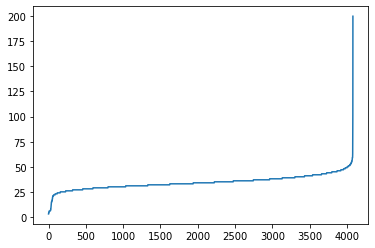

In [8]:
plt.plot(
    range(len(poems)),
    [len(poem) for poem in poems]
)
plt.show()

In [9]:
tokens = ["<PAD>"]
tokens.extend(
    sorted(set(itertools.chain.from_iterable(poems)))
)

idx_token_map = {idx: token for idx, token in enumerate(tokens)}
token_idx_map = {token: idx for idx, token in enumerate(tokens)}

num_tokens = len(tokens)

print(num_tokens)

print(sorted(tokens, key=len)[-10:])
print(sorted(tokens, key=len)[:10])

20516
['многозначительно', 'наследственность', 'неограниченности', 'несправедливость', 'принципиальность', 'распространенней', 'безнравственность', 'загипнотизировали', 'политиканствующим', 'сентиментальности']
['\n', '!', ',', '.', ':', '?', 'а', 'б', 'в', 'д']


3700


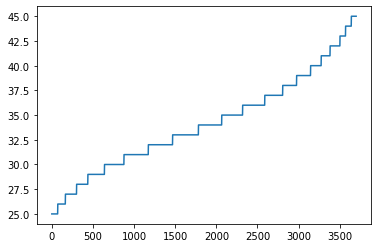

In [10]:
poems = [poem for poem in poems if 25 <= len(poem) <= 45]
poems = poems[:len(poems) - len(poems) % BATCH_SIZE]

print(len(poems))

plt.plot(
    range(len(poems)),
    [len(poem) for poem in poems]
)
plt.show()

In [11]:
print([token_idx_map[x] for x in ("<PAD>", "<SOS>", "<EOS>")])

[0, 7, 6]


In [12]:
def poems_to_matrix(poems):       
    poems_ix = np.zeros([len(poems), max(map(len, poems))], dtype=np.int32)

    for i in range(len(poems)):
        line_ix = [token_idx_map[t] for t in poems[i]]
        poems_ix[i, :len(line_ix)] = line_ix
        
    return poems_ix

In [13]:
def batch_gen():
    batches = [poems_to_matrix(poems[i : i + BATCH_SIZE]) for i in range(0, len(poems), BATCH_SIZE)]
    np.random.shuffle(batches)
    for batch in batches:
        x = batch[:, :-1]
        y = batch[:, 1:]
        yield torch.LongTensor(x), torch.LongTensor(y)

In [14]:
def create_emb_layer(num_tokens, emb_dim=64, non_trainable=False):
    wv = Word2Vec(poems, epochs=5, vector_size=emb_dim, sg=1, hs=1).wv
    matrix_len = num_tokens
    weights_matrix = np.zeros((num_tokens, emb_dim))
    words_found = 0

    for i, word in enumerate(tokens):
        try:
            weights_matrix[i] = wv[word]
        except Exception:
            weights_matrix[i] = np.random.normal(scale=0.5, size=(emb_dim, ))
    
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.Tensor(weights_matrix)})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer

In [15]:
class WordRNN(nn.Module):
    def __init__(self, num_tokens, emb_size=32, hidden_size=128, num_layers=1):
        super().__init__()
        
        self.num_tokens = num_tokens
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.encoder = create_emb_layer(num_tokens, emb_dim=emb_size, non_trainable=False)
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_size, num_tokens)
        
    def forward(self, x, prev_hidden):
        embed = self.encoder(x)
        output, hidden = self.rnn(embed, prev_hidden)
        logits = self.decoder(output)
        return logits, hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

In [16]:
def train_RNN(device, model, opt, criterion, num_epochs=80, plot=True):
    model.train()
    model = model.to(device)
    loss_history = []
    for epoch in range(num_epochs):

        hidden = model.init_hidden(BATCH_SIZE)
        hidden = hidden.to(device)

        batches = batch_gen()

        for i, (x, y) in enumerate(batches):
            opt.zero_grad()
    
            x = x.to(device)
            y = y.to(device)
    
            logits, hidden = model(x, hidden)
    
            loss = criterion(logits.view(-1, num_tokens), y.view(-1))
            hidden = hidden.detach()
               
            loss.backward()
            _ = torch.nn.utils.clip_grad_norm_(
                model.parameters(), 
                2
            )
            opt.step()
    
            loss_history.append(loss.item())
    
        if plot:
            clear_output(wait=True)
            plt.plot(loss_history)
            plt.show()
        else:
            print(f"Epoch: {epoch}, Loss: {loss_history[-1]}")

In [17]:
def beautify_text(words, sep=" "):
    res = ""
    
    last_is_punct = True
    need_capitalize = True
    for w in words[1:-1]:
        if w in string.punctuation:
            if last_is_punct:
                continue
            res += w
            last_is_punct = True
            if w in '.!?':
                need_capitalize = True
            else:
                need_capitalize = False
        elif w == "\n":
            res += w
        else:
            if need_capitalize:
                w = w.capitalize()
            res += sep + w
            last_is_punct = False
            need_capitalize = False
    res = res.strip("\n,:")
    if res[-1] not in ("\n", ".", "!", "?"):
        res += "."
    return res

In [18]:
def generate_poem_RNN(device, model, num_tokens, token_idx_map, idx_token_map, words=None, top_k=None):
    if top_k is None:
        top_k = num_tokens
    if words is None:
        while True:
            random_word = np.random.choice(list(token_idx_map))
            if not (random_word in string.punctuation or random_word in ("\n", "<SOS>", "<EOS>", "<PAD>")):
                break
        words = ["<SOS>"] + [random_word]
    else:
        words = ["<SOS>"] + words
    
    model.eval()
    
    hidden = model.init_hidden(batch_size=1)
    hidden = hidden.to(device)
    for w in words:
        ix = torch.tensor([[token_idx_map[w]]]).to(device)
        output, hidden = model(ix, hidden)
    
    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0])
    
    words.append(idx_token_map[choice])
    
    while True:
        ix = torch.tensor([[choice]]).to(device)
        output, hidden = model(ix, hidden)
        
        logits, top_ix = torch.topk(output[0], k=top_k)
        choices = top_ix.tolist()[0]
        logits = logits.detach().cpu().view(-1)
        p = F.softmax(logits, -1).numpy()
        choice = np.random.choice(choices, p=p)
    
        words.append(idx_token_map[choice])
        if idx_token_map[choice] == "<EOS>":
            break
    res = beautify_text(words)
    print(res)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn = WordRNN(num_tokens, emb_size=64, hidden_size=256)
opt_rnn = torch.optim.Adam(rnn.parameters(), lr=1e-3)
criterion_rnn = nn.CrossEntropyLoss(ignore_index=0)

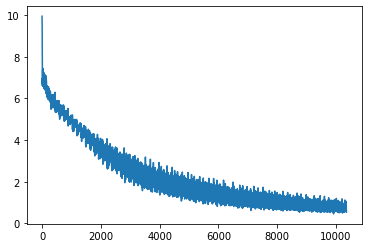

In [20]:
train_RNN(device, rnn, opt_rnn, criterion_rnn, num_epochs=70, plot=True)

In [21]:
torch.save(rnn, "rnn.pt")
del rnn
rnn = torch.load("rnn.pt")

In [22]:
for i in range(10):
    if i < 3:
        print("Рандомное слово для инициализации, argmax вероятности для выбора следующего слова")
        print(100 * "-")
        generate_poem_RNN(device, rnn, num_tokens, token_idx_map, idx_token_map, top_k=1)
    elif i < 6:
        print("Рандомное слово для инициализации, подбрасываем монетку с вероятностями для выбора следующего слова")
        print(100 * "-")
        generate_poem_RNN(device, rnn, num_tokens, token_idx_map, idx_token_map)
    elif i == 6:
        print("Слово 'любовь' для инициализации, argmax вероятности для выбора следующего слова")
        print(100 * "-")
        generate_poem_RNN(device, rnn, num_tokens, token_idx_map, idx_token_map, words=["любовь"], top_k=1)
    else:
        print("Слово 'любовь' для инициализации, подбрасываем монетку с вероятностями для выбора следующего слова среди топ-5 кандидатов")
        print(100 * "-")
        generate_poem_RNN(device, rnn, num_tokens, token_idx_map, idx_token_map, words=["любовь"], top_k=5)
    print(100 * "-")
    print("\n")

Рандомное слово для инициализации, argmax вероятности для выбора следующего слова
----------------------------------------------------------------------------------------------------
 Мысли в восторге по набережной хмурой
 парень чуть слышно, все моря,
 будто в праздник, радостью в стихах,
 полыхает плакатами и цветами.
----------------------------------------------------------------------------------------------------


Рандомное слово для инициализации, argmax вероятности для выбора следующего слова
----------------------------------------------------------------------------------------------------
 Кожа. Но только ты не раз,
 ведь мы же когда нибудь слетаем
 в том, что в летнем цирке в третий раз
 с большим аттракционом выступает
 джаз лилипутов театральный джаз!
----------------------------------------------------------------------------------------------------


Рандомное слово для инициализации, argmax вероятности для выбора следующего слова
--------------------------------------

In [23]:
class WordLSTM(nn.Module):
    def __init__(self, num_tokens, emb_size=32, hidden_size=128, num_layers=1):
        super().__init__()
        
        self.num_tokens = num_tokens
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.encoder = create_emb_layer(num_tokens, emb_dim=emb_size, non_trainable=False)
        self.lstm = nn.LSTM(emb_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_size, num_tokens)
        
    def forward(self, x, prev_hidden):
        embed = self.encoder(x)
        output, hidden = self.lstm(embed, prev_hidden)
        logits = self.decoder(output)
        return logits, hidden
    
    def init_hidden(self, batch_size):
        return (
            torch.zeros(self.num_layers, batch_size, self.hidden_size),
            torch.zeros(self.num_layers, batch_size, self.hidden_size)
        )

In [24]:
def train_LSTM(device, model, opt, criterion, num_epochs=80, plot=True):
    model.train()
    model = model.to(device)
    loss_history = []
    for epoch in range(num_epochs):

        hidden_s, hidden_c = model.init_hidden(BATCH_SIZE)
        hidden_s = hidden_s.to(device)
        hidden_c = hidden_c.to(device)

        batches = batch_gen()

        for i, (x, y) in enumerate(batches):
            opt.zero_grad()
    
            x = x.to(device)
            y = y.to(device)
    
            logits, (hidden_s, hidden_c) = model(x, (hidden_s, hidden_c))
    
            loss = criterion(logits.view(-1, num_tokens), y.view(-1))
            hidden_s = hidden_s.detach()
            hidden_c = hidden_c.detach()
               
            loss.backward()
            _ = torch.nn.utils.clip_grad_norm_(
                model.parameters(), 
                2
            )
            opt.step()
    
            loss_history.append(loss.item())
    
        if plot:
            clear_output(wait=True)
            plt.plot(loss_history)
            plt.show()
        else:
            print(f"Epoch: {epoch}, Loss: {loss_history[-1]}")

In [25]:
lstm = WordLSTM(num_tokens, emb_size=64, hidden_size=256)
opt_lstm = torch.optim.Adam(lstm.parameters(), lr=1e-3)
criterion_lstm = nn.CrossEntropyLoss(ignore_index=0)

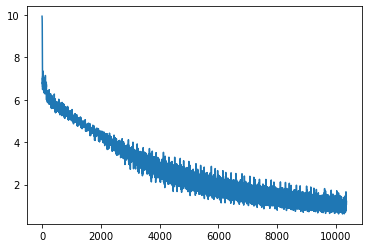

In [26]:
train_LSTM(device, lstm, opt_lstm, criterion_lstm, num_epochs=70, plot=True)

In [27]:
def generate_poem_LSTM(device, model, num_tokens, token_idx_map, idx_token_map, words=None, top_k=None):
    if top_k is None:
        top_k = num_tokens
    if words is None:
        while True:
            random_word = np.random.choice(list(token_idx_map))
            if not (random_word in string.punctuation or random_word in ("\n", "<SOS>", "<EOS>", "<PAD>")):
                break
        words = ["<SOS>"] + [random_word]
    else:
        words = ["<SOS>"] + words
    
    model.eval()
    
    hidden_s, hidden_c = model.init_hidden(batch_size=1)
    hidden_s = hidden_s.to(device)
    hidden_c = hidden_c.to(device)
    for w in words:
        ix = torch.tensor([[token_idx_map[w]]]).to(device)
        output, (hidden_s, hidden_c) = model(ix, (hidden_s, hidden_c))
    
    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0])
    
    words.append(idx_token_map[choice])
    
    while True:
        ix = torch.tensor([[choice]]).to(device)
        output, (hidden_s, hidden_c) = model(ix, (hidden_s, hidden_c))
        
        logits, top_ix = torch.topk(output[0], k=top_k)
        choices = top_ix.tolist()[0]
        logits = logits.detach().cpu().view(-1)
        p = F.softmax(logits, -1).numpy()
        choice = np.random.choice(choices, p=p)
    
        words.append(idx_token_map[choice])
        if idx_token_map[choice] == "<EOS>":
            break
    res = beautify_text(words)
    print(res)

In [28]:
for i in range(10):
    if i < 3:
        print("Рандомное слово для инициализации, argmax вероятности для выбора следующего слова")
        print(100 * "-")
        generate_poem_LSTM(device, lstm, num_tokens, token_idx_map, idx_token_map, top_k=1)
    elif i < 6:
        print("Рандомное слово для инициализации, подбрасываем монетку с вероятностями для выбора следующего слова")
        print(100 * "-")
        generate_poem_LSTM(device, lstm, num_tokens, token_idx_map, idx_token_map)
    elif i == 6:
        print("Слово 'любовь' для инициализации, argmax вероятности для выбора следующего слова")
        print(100 * "-")
        generate_poem_LSTM(device, lstm, num_tokens, token_idx_map, idx_token_map, words=["любовь"], top_k=1)
    else:
        print("Слово 'любовь' для инициализации, подбрасываем монетку с вероятностями для выбора следующего слова среди топ-5 кандидатов")
        print(100 * "-")
        generate_poem_LSTM(device, lstm, num_tokens, token_idx_map, idx_token_map, words=["любовь"], top_k=5)
    print(100 * "-")
    print("\n")

Рандомное слово для инициализации, argmax вероятности для выбора следующего слова
----------------------------------------------------------------------------------------------------
 Позванивают в сердце, что хапают и прячут,
 что за то, что честь, то с ней,
 в то время как на миг нет,
 не спеши, не руби с плеча.
----------------------------------------------------------------------------------------------------


Рандомное слово для инициализации, argmax вероятности для выбора следующего слова
----------------------------------------------------------------------------------------------------
 Барак, как рыба, ныряет нет,
 что счастье сомненья и верно,
 и в этом союзе, что с укором,
 то, в сердце ты не ты мне?
----------------------------------------------------------------------------------------------------


Рандомное слово для инициализации, argmax вероятности для выбора следующего слова
---------------------------------------------------------------------------------------------

Поэзия LSTM понравилась больше